## Load Packages

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

import numpy as np
import seaborn as sns
import math
import bayesflow as bf
import os
from numba import njit
import numba as nb
import random
import pandas as pd
from pathlib import Path
import ipynbname
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)
RNG = np.random.default_rng(2023)


C:\Users\u0145642\AppData\Roaming\Python\Python311\site-packages\bayesflow\trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Get file path

In [2]:
notebook_path = Path(ipynbname.path()).resolve().parent
root_dir = notebook_path.parent
print(root_dir)

C:\Users\u0145642\OneDrive - KU Leuven\Desktop\Robust amortized Bayesian inference\1 parameter recovery study


## Get checkpoint path

In [3]:
checkpoint_path = root_dir / "network"

## Define DDM
Define one trial in DDM.

In [4]:
@nb.jit(nopython=True, cache=True)
def diffusion_trial(v, a, ndt, dt=1e-3, max_steps=15000):
    """Simulates a trial from the diffusion model."""
    n_steps = 0
    x = a * 0.5
    mu = v * dt
    sigma = math.sqrt(dt)

    # Simulate a single DM path
    for n_steps in range(max_steps):
        # DDM equation
        x += mu + sigma * np.random.normal(0,1)
        # Stop when out of bounds
        if x <= 0.0 or x >= a:
            break
    
    rt = float(n_steps) * dt
    
    if x > 0:
        resp = 1.
    else:
        resp = 0.
    return rt+ndt,resp


## Define priors

In [5]:
def diffusion_prior():
    "Generates a random draw from the joint prior distribution."
    #normal distribution for the drift rates
    drifts_1 = RNG.uniform(0.5,2)
    threshold = RNG.uniform(0.7,5)
    ndt = RNG.gamma(1.5, 1 / 5.0)
    return np.hstack((drifts_1, threshold, ndt))

PARAM_NAMES = [
    "Drift Rate",
    "Boundary Separation",
    "Non-decision Time"
]

prior = bf.simulation.Prior(prior_fun=diffusion_prior, param_names=PARAM_NAMES)

## Define the study design information
Set the trial number $n$ to be 100, and the number of condition to be 1.

In [6]:
def random_num_obs():
    """100 observations for all simulations in a batch."""

    return 100

num_obs = 100

def generate_condition_matrix(num_obs, num_conditions=1):
    """Draws a random design matrix for each simulation in a batch."""

    obs_per_condition = np.ceil(num_obs / num_conditions)
    condition = np.arange(num_conditions)
    condition = np.repeat(condition, obs_per_condition)
    return condition[:num_obs]

context_gen = bf.simulation.ContextGenerator(
    non_batchable_context_fun=random_num_obs,
    batchable_context_fun=generate_condition_matrix,
    use_non_batchable_for_batchable=True
)

## Combine the design information and the trial-wise simulator

In [7]:
@nb.jit(nopython=True,parallel=True)
def diffusion_experiment(theta, design_matrix, rng=None, *args):
    
    out = np.zeros((num_obs, 2))
    for n in range(num_obs):
        index = design_matrix[n]
        rt,resp = diffusion_trial(theta[index], theta[-2], theta[-1])
        out[n, :] = np.array([rt,resp])
    
    out[:,0] = np.log(out[:,0])
    
    return out


## Wrap the simulator and the model up

In [8]:
simulator = bf.simulation.Simulator(simulator_fun=diffusion_experiment, context_generator=context_gen)
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator, name="DDM")

INFO:root:Performing 2 pilot runs with the DDM model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Could not determine shape of simulation non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes cares of that!


## Configurator

In [9]:
from tensorflow.keras.utils import to_categorical

#a configurator extracts the results of the model to a format that the neural network would like
def configurator(forward_dict):
    """Configure the output of the GenerativeModel for a BayesFlow setup."""

    # Prepare placeholder dict
    out_dict = {}

    # Extract simulated response times
    data = forward_dict["sim_data"]

    # Convert list of condition indicators to a 2D array and add a
    # trailing dimension of 1, so shape becomes (batch_size, num_obs, 1)
    # We need this in order to easily concatenate the context with the data
    context = np.array(forward_dict["sim_batchable_context"])[..., None]

    # One-hot encoding of integer choices
    categorical_resp = to_categorical(data[:, :, 1], num_classes=2)

    # Concatenate rt, resp, context
    out_dict["summary_conditions"] = np.c_[data[:, :, :1], categorical_resp, context].astype(np.float32)

    # Make inference network aware of varying numbers of trials
    # We create a vector of shape (batch_size, 1) by repeating the sqrt(num_obs)
    vec_num_obs = forward_dict["sim_non_batchable_context"] * np.ones((data.shape[0], 1))
    out_dict["direct_conditions"] = np.sqrt(vec_num_obs).astype(np.float32)

    # Get data generating parameters
    out_dict["parameters"] = forward_dict["prior_draws"].astype(np.float32)


    return out_dict



## Networks

In [10]:
summary_net = bf.networks.SetTransformer(input_dim=4, summary_dim=3, name="ddm_summary")

inference_net = bf.networks.InvertibleNetwork(
    num_params=len(prior.param_names),
    coupling_settings={"dense_args": dict(kernel_regularizer=None),"dropout_prob":0.2, "bins":32},
    coupling_design="spline",
    name="ddm_inference",
)

amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name="ddm_amortizer")

trainer = bf.trainers.Trainer(
    generative_model=model, amortizer=amortizer, configurator=configurator,
    checkpoint_path = checkpoint_path
)
amortizer.summary()


INFO:root:Loaded loss history from C:\Users\u0145642\OneDrive - KU Leuven\Desktop\Robust amortized Bayesian inference\1 parameter recovery study\network\history_100.pkl.
INFO:root:Networks loaded from C:\Users\u0145642\OneDrive - KU Leuven\Desktop\Robust amortized Bayesian inference\1 parameter recovery study\network\ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "ddm_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ddm_inference (InvertibleN  multiple                  433434    
 etwork)                                                         
                                                                 
 ddm_summary (SetTransforme  multiple                  40172     
 r)                                                              
                                                                 
Total params: 473606 (1.81 MB)
Trainable params: 473570 (1.81 MB)
Non-trainable params: 36 (144.00 Byte)
_________________________________________________________________


## Train the Model

In [11]:
## Uncomment if you want to train the network yourself
#history = trainer.train_online(epochs=100, iterations_per_epoch=1000, batch_size=32)

## Compare the estimation of BayesFlow and JAGS

### Simulate data and store it (move to R JAGS)

The data is simulated with validation_sims_ez =  model(batch_size=500) and stored locally. Read the file by %store -r command.

In [12]:
# %store -r validation_sims_ez
# data = validation_sims_ez['summary_conditions'].reshape(500*100,4)
# #add an data index
# data_index = np.repeat(np.arange(1,501), 100).reshape(500*100,1)
# data = np.concatenate((data, data_index), axis=1)
# np.savetxt(root_dir / 'JAGS related files/data_bf.txt', data, delimiter=',')

### Inference from EZ, BayesFlow, and JAGS

In [11]:
%store -r validation_sims_ez

#########################
#Inference from BayesFlow
post_samples = amortizer.sample(validation_sims_ez, n_samples=1000)
post_samples_sd = np.std(post_samples, axis=1)
post_samples = np.mean(post_samples, axis=1)

####################
#Inference from Jags
file_path_mean = root_dir /'JAGS related files/posterior_mean_JAGS.txt'  # Update with the path to your text file
file_path_sd = root_dir / 'JAGS related files/posterior_sd_JAGS.txt'  # Update with the path to your text file
delimiter = ','  # Update with the delimiter used in your text file
# Read the text file into a Pandas DataFrame
posterior_mean_jags = pd.read_csv(file_path_mean, delimiter=delimiter)
posterior_sd_jags = pd.read_csv(file_path_sd, delimiter=delimiter)
#non-convergence index
posterior_mean_jags[posterior_mean_jags['convergence']==0].index

############################
#Inference from EZ diffusion
#transform the log RTs back to original scale
validation_sims_ez_exp = validation_sims_ez
validation_sims_ez_exp['summary_conditions'][:,:,0]= np.exp(validation_sims_ez_exp['summary_conditions'][:,:,0])
#MRT
MRT = []
for i in range(validation_sims_ez['summary_conditions'][:,0:num_obs,:].shape[0]):
    mean_pp = np.mean(validation_sims_ez_exp['summary_conditions'][i,0:num_obs,0][validation_sims_ez_exp['summary_conditions'][i,0:num_obs,1] == 0])
    MRT.append(mean_pp)   
#Proportion of Correctness
Pc = np.mean(validation_sims_ez['summary_conditions'][:,0:num_obs,2],axis=1)
Pc[Pc == 1] = 1-1/((2*num_obs) + np.random.normal(0,20))
Pc[Pc == 0] = 1/(2*num_obs + np.random.normal(0,20)) 
Pc[Pc == 0.5] = 0.5+1/(2*num_obs + np.random.normal(0,20))
#Variance in reaction time of the correct response
VRT = []
for i in range(validation_sims_ez['summary_conditions'][:,0:num_obs,:].shape[0]):
    variance_pp = np.var(validation_sims_ez_exp['summary_conditions'][i,0:num_obs,0][validation_sims_ez_exp['summary_conditions'][i,0:num_obs,1] == 0])
    VRT.append(variance_pp)
    
    
def get_vaTer_function(Pc, VRT, MRT, s):
    s2 = s**2
    L = np.log(Pc / (1 - Pc))
    x = L * (L * Pc**2 - L * Pc + Pc - 0.5) / VRT
    v = np.sign(Pc - 0.5) * s * np.power(x, 1/4)
    a = (s2 * L) / v
    y = (-v * a) / s2
    MDT = (a / (2 * v)) * (1 - np.exp(y)) / (1 + np.exp(y))
    Ter = MRT - MDT

    return np.stack((v, a, Ter), axis = 1)

ez = get_vaTer_function(Pc=Pc, VRT= VRT, MRT=MRT, s=1)

#############################################
#exclude the non-convergence data & inference
post_samples = np.delete(post_samples, posterior_mean_jags[posterior_mean_jags['convergence']==0].index, axis=0)
post_samples_sd = np.delete(post_samples_sd, posterior_mean_jags[posterior_mean_jags['convergence']==0].index, axis=0)
ez = np.delete(ez, posterior_mean_jags[posterior_mean_jags['convergence']==0].index, axis=0)
true_parameter = np.delete(validation_sims_ez['parameters'],posterior_mean_jags[posterior_mean_jags['convergence']==0].index, axis=0)
posterior_mean_jags = posterior_mean_jags.drop(posterior_mean_jags[posterior_mean_jags['convergence']==0].index)
posterior_sd_jags = posterior_sd_jags.drop(posterior_sd_jags[posterior_sd_jags['convergence']==0].index)

## Parameter recovery of three methods

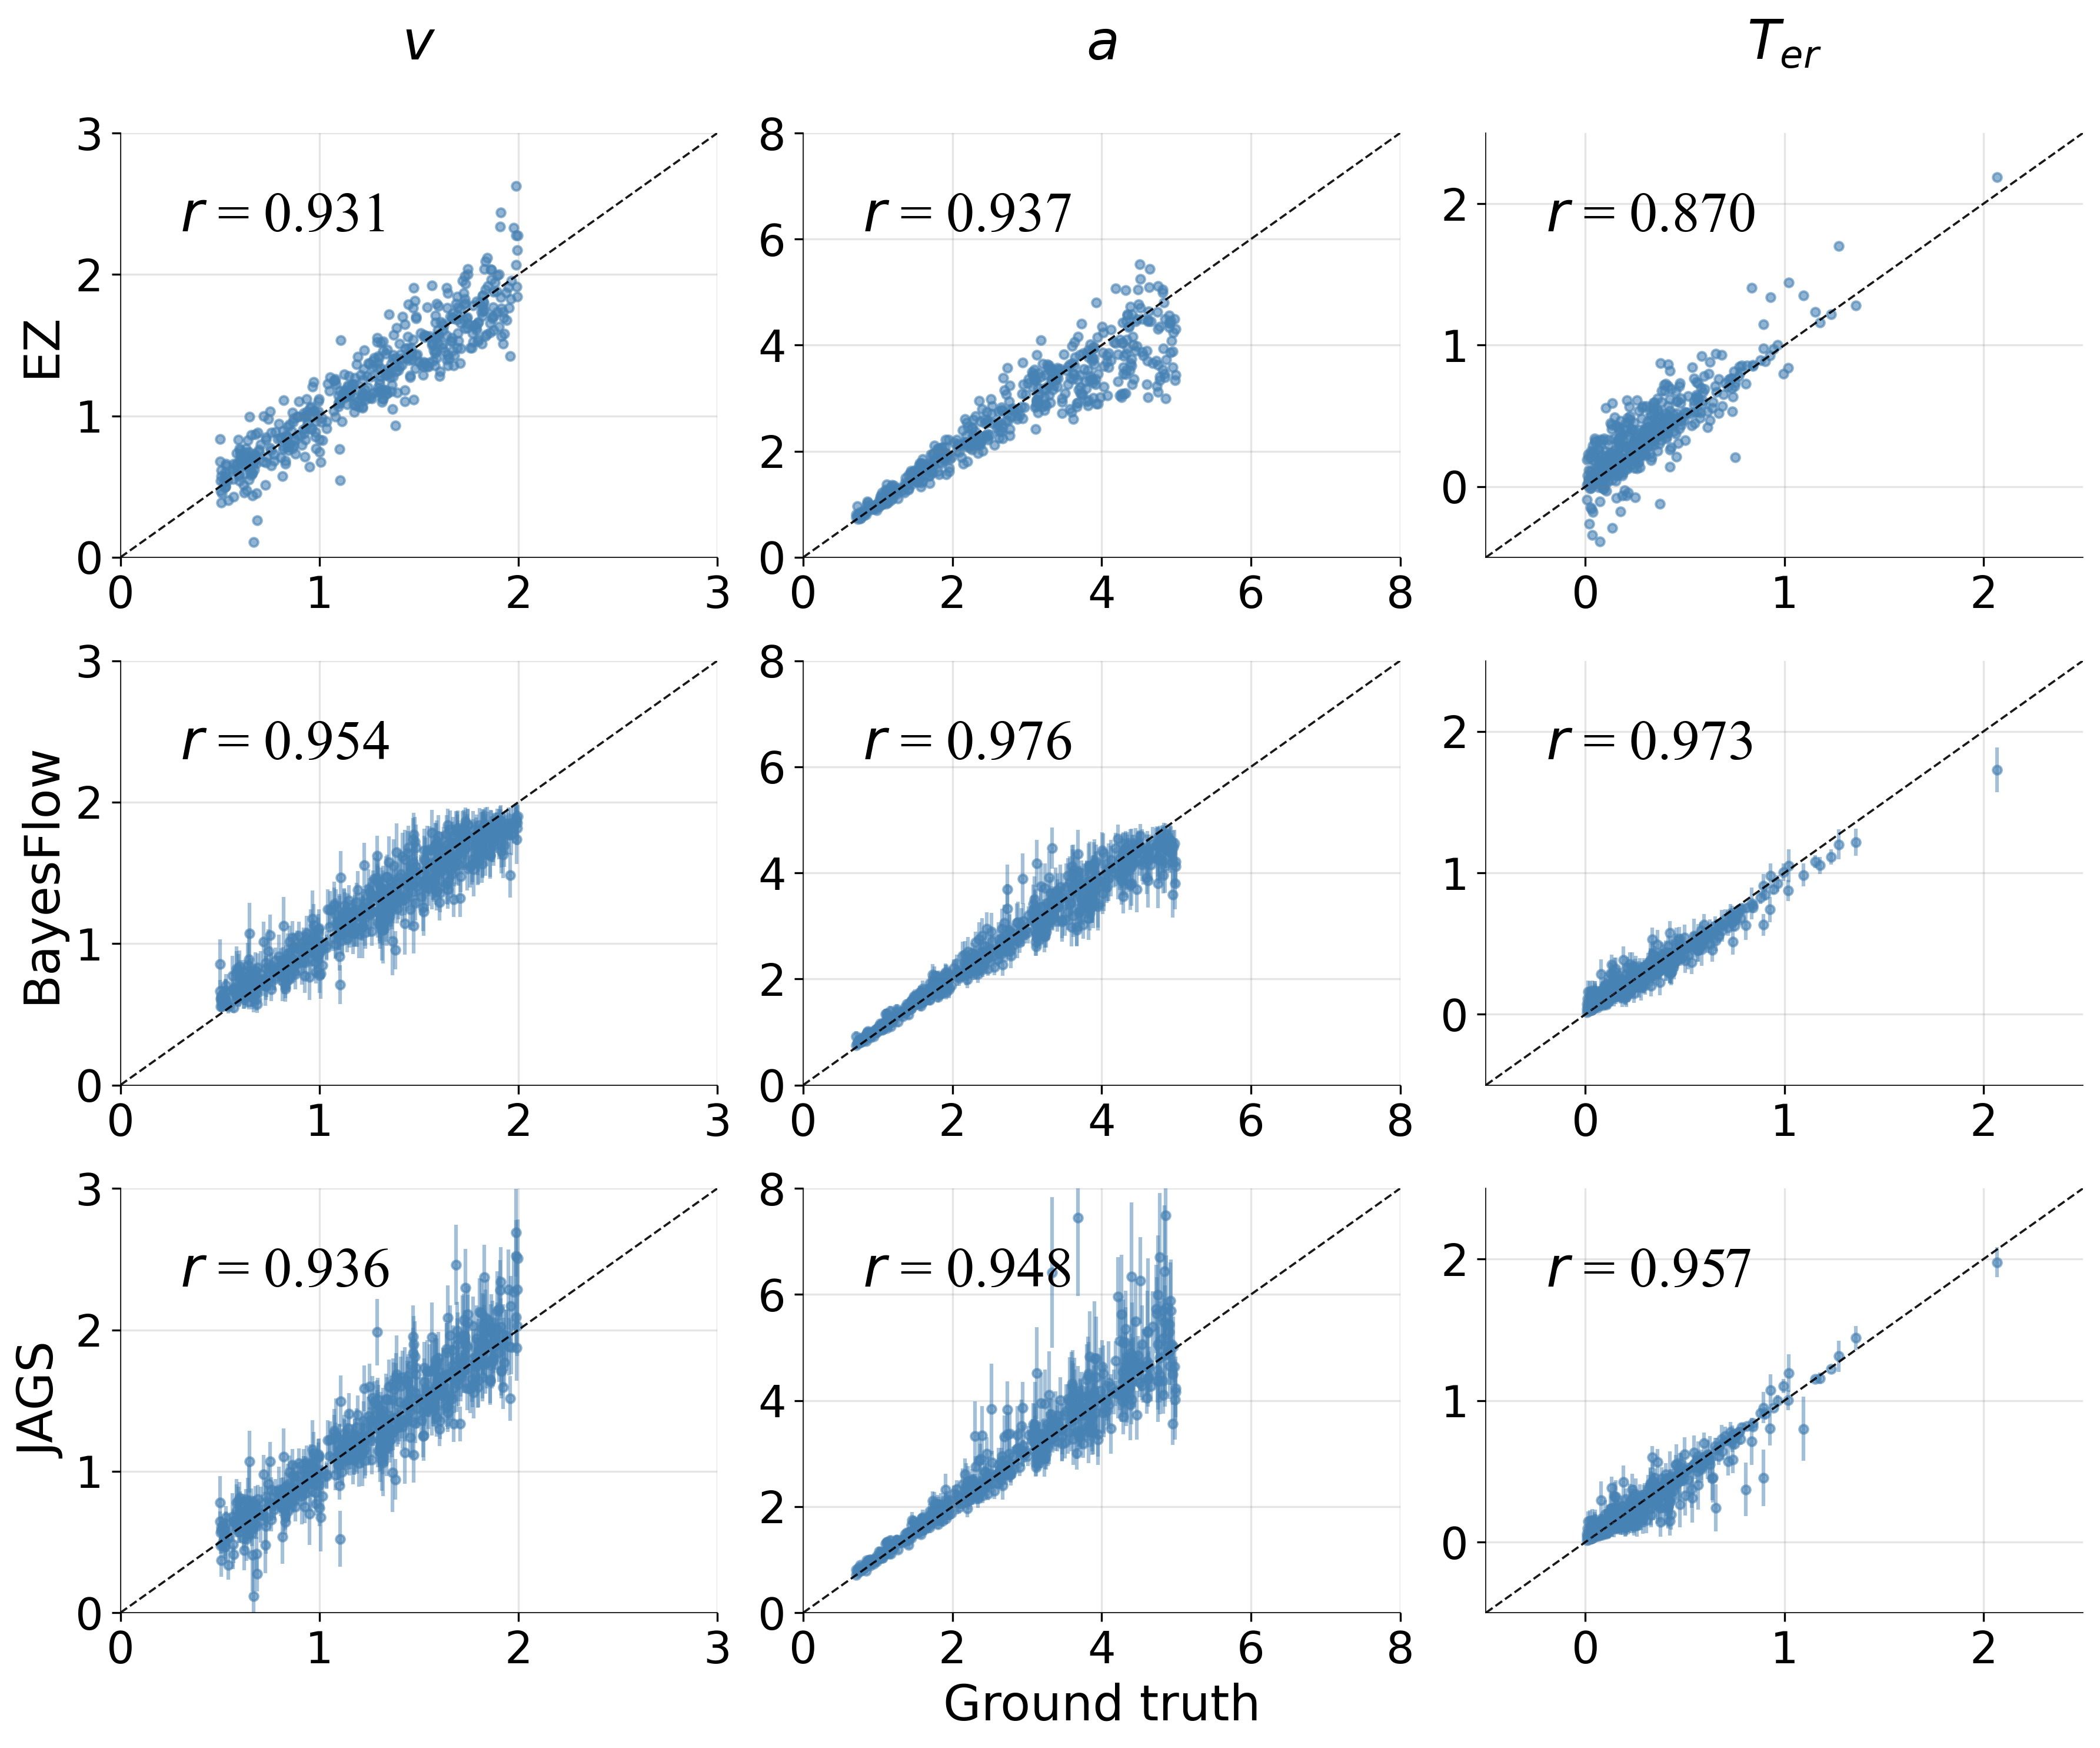

In [12]:
title_size = 22
label_size = 20
r_size = 23
tick_size = 18

test_sims = validation_sims_ez
# Create the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=300, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.rcParams['font.family'] = 'Times New Roman'

parameter_name = ["delta", "alpha", "tau"]
titles = [r'$v$', r'$a$', r'$T_{er}$']
ylabels = ['EZ', 'BayesFlow', 'JAGS']

# Function to plot each subplot
def plot_subplot(ax, x, y, yerr=None, title=None, xlabel='Ground truth', ylabel=None):
    ax.scatter(x, y, marker='o', s=12, color='steelblue', alpha=0.6)
    if yerr is not None:
        ax.errorbar(x, y, yerr=yerr, fmt=',', alpha=0.5, color="steelblue")
    lower = min(x.min(), y.min())
    upper = max(x.max(), y.max())
    eps = (upper - lower) * 0.1
    ax.set_title(title, fontsize=title_size, pad =30)
    ax.set_xlabel(xlabel, fontsize=label_size)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=label_size)
    corr = np.corrcoef(x, y)[0, 1]
    ax.text(
        0.1, 0.8,
        "$r$ = {:.3f}".format(corr),
        horizontalalignment="left",
        verticalalignment="center",
        transform=ax.transAxes,
        size=23
    )
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='grey', linestyle='-', alpha=0.2)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)
    for spine in ax.spines.values():
        spine.set_linewidth(0.4)

x_limits = [
    (0, 3),  # Drift rate
    (0, 8),  # Boundary separation
    (-0.5, 2.5) # Non-decision time
]

y_limits = [
    (0, 3),  # Drift rate
    (0, 8),  # Boundary separation
    (-0.5, 2.5) # Non-decision time
]


# Populate the subplots
for row, (y, yerr) in enumerate([
    (ez, None), 
    (post_samples, post_samples_sd),
    (np.column_stack([posterior_mean_jags[param] for param in parameter_name]),
     np.column_stack([posterior_sd_jags[param] for param in parameter_name]))
]):
    for col in range(3):
        plot_subplot(
            axes[row, col],
            true_parameter[:, col],
            y[:, col] if isinstance(y, np.ndarray) else y[parameter_name[col]],
            yerr=yerr[:, col] if yerr is not None and isinstance(yerr, np.ndarray) else (yerr[parameter_name[col]] if yerr is not None else None),
            title=titles[col] if row == 0 else None,  # Titles only for the first row
            xlabel='Ground truth' if row == 2 and col == 1 else None,
            ylabel=ylabels[row] if col == 0 else None  # Unique y-labels for the first column of each row
        )
        # Set specific x-axis limits for each column
        axes[row, col].set_xlim(x_limits[col])
        axes[row, col].set_ylim(y_limits[col])
        
        # Dynamically set the diagonal dashed line
        x_min, x_max = axes[row, col].get_xlim()
        y_min, y_max = axes[row, col].get_ylim()
        diag_min = min(x_min, y_min)  # Start from the minimum of x and y
        diag_max = max(x_max, y_max)  # Extend to the maximum of x and y
        axes[row, col].plot(
            [diag_min, diag_max], [diag_min, diag_max],
            color='black', alpha=0.9, linestyle="dashed", label='Diagonal Line', linewidth=0.9
        )

plt.tight_layout()
plt.savefig(root_dir / 'plots/parameter_recovery_combined.pdf', format="pdf", bbox_inches="tight")
plt.show()




## Compare between different estimation

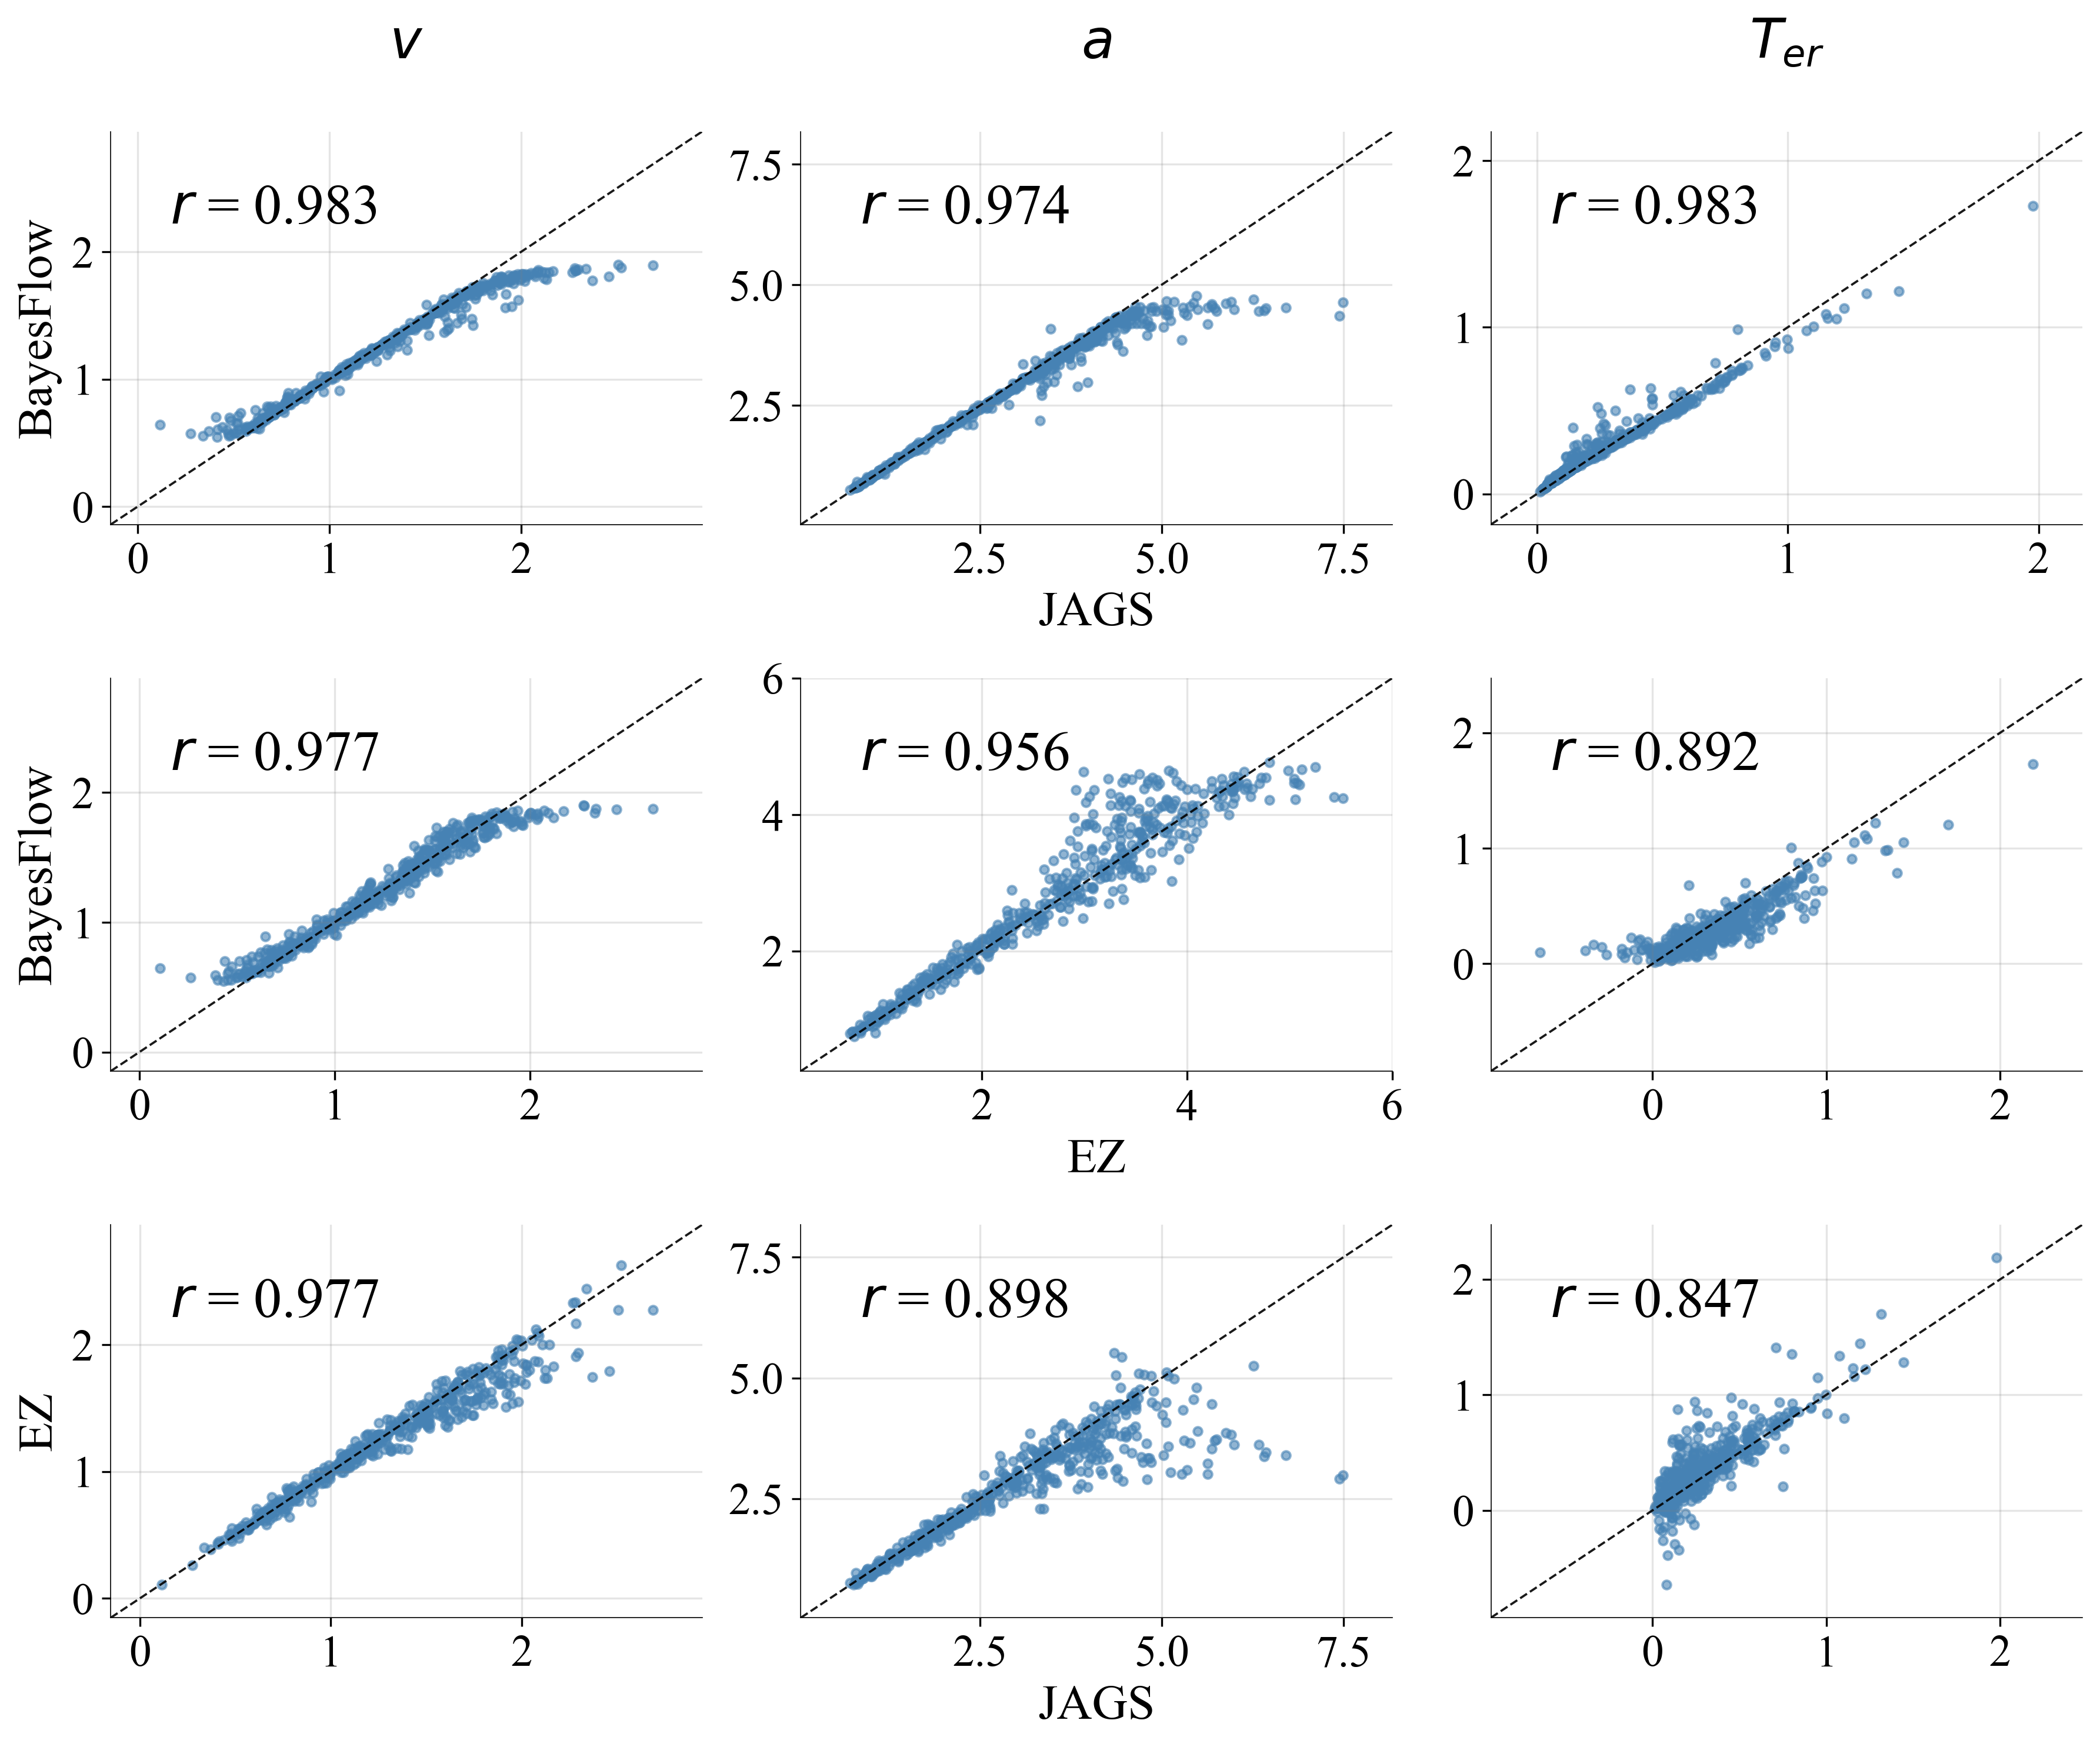

In [13]:
# Create the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=300, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.rcParams['font.family'] = 'Times New Roman'

parameter_name = ["delta", "alpha", "tau"]
titles = [r'$v$', r'$a$', r'$T_{er}$']

# Plot data for each comparison
comparisons = [
    ('JAGS', 'BayesFlow', posterior_mean_jags, post_samples),
    ('EZ', 'BayesFlow', ez, post_samples),
    ('JAGS',  'EZ', posterior_mean_jags, ez)
]

for row, (x_label, y_label, x_data, y_data) in enumerate(comparisons):
    for col in range(3):  # Columns correspond to parameters
        ax = axes[row, col]
        
        # Access x_data and y_data
        x_values = x_data[parameter_name[col]].values if isinstance(x_data, pd.DataFrame) else x_data[:, col]
        y_values = y_data[:, col]  # Assuming y_data is always a NumPy array
        
        lower = min(x_values.min(), y_values.min())
        upper = max(x_values.max(), y_values.max())
        eps = (upper - lower) * 0.1
        
        ax.scatter(x_values, y_values, marker='o', s=12, color='steelblue', alpha=0.6)
        ax.plot([lower - eps, upper + eps], [lower - eps, upper + eps],
                color='black', alpha=0.9, linestyle="dashed", label='Diagonal Line', linewidth=0.9)
        
        ax.set_xlim([lower - eps, upper + eps])
        ax.set_ylim([lower - eps, upper + eps])
        if col == 1:
            ax.set_xlabel(x_label, size=label_size)
        if col == 0:
            ax.set_ylabel(y_label, size=label_size)
        
        # Add title for the top row
        if row == 0:
            ax.set_title(titles[col], size=title_size, pad=30)
        
        # Add correlation coefficient
        corr = np.corrcoef(x_values, y_values)[0, 1]
        ax.text(0.1, 0.8, "$r$ = {:.3f}".format(corr),
                horizontalalignment="left", verticalalignment="center",
                transform=ax.transAxes, size=r_size)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Set grey grid
        ax.grid(color='grey', linestyle='-', alpha=0.2)
        
        # Show only bottom and left ticks
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        ax.tick_params(axis='x', labelsize=tick_size)
        ax.tick_params(axis='y', labelsize=tick_size)
        
        for spine in ax.spines.values():
            spine.set_linewidth(0.4)  # Adjust the line width

plt.tight_layout()
plt.savefig(root_dir / 'plots/combined_comparisons.pdf', format="pdf", bbox_inches="tight")
plt.show()

## Calculate the RMSE and posterior standard deviation

In [25]:
true_v = true_parameter[:,0]
true_a = true_parameter[:,1]
true_Ter = true_parameter[:,2]

#RMSE EZ diffusion
rmse_ez_v = np.round(np.power(np.mean(np.power(np.abs(ez[:,0]-true_v),2)),1/2),3)
rmse_ez_a = np.round(np.power(np.mean(np.power(np.abs(ez[:,1]-true_a),2)),1/2),3)
rmse_ez_Ter = np.round(np.power(np.mean(np.power(np.abs(ez[:,2]-true_Ter),2)),1/2),3)

#RMSE JAGS
parameter_name = ["delta","alpha", "tau"]
rmse_jags_v = np.round(np.power(np.mean(np.power(np.abs(posterior_mean_jags['delta']-true_v),2)),1/2),3)
rmse_jags_a = np.round(np.power(np.mean(np.power(np.abs(posterior_mean_jags['alpha']-true_a),2)),1/2),3)
rmse_jags_Ter = np.round(np.power(np.mean(np.power(np.abs(posterior_mean_jags['tau']-true_Ter),2)),1/2),3)

#RMSE BayesFlow
rmse_bf_v = np.round(np.power(np.mean(np.power(np.abs(post_samples[:,0]-true_v),2)),1/2),3)
rmse_bf_a = np.round(np.power(np.mean(np.power(np.abs(post_samples[:,1]-true_a),2)),1/2),3)
rmse_bf_Ter = np.round(np.power(np.mean(np.power(np.abs(post_samples[:,2]-true_Ter),2)),1/2),3)

print('RMSE EZ diffusion:', rmse_ez_v,rmse_ez_a,rmse_ez_Ter)
print('RMSE JAGS:', rmse_jags_v,rmse_jags_a,rmse_jags_Ter)
print('RMSE BayesFlow:', rmse_bf_v,rmse_bf_a,rmse_bf_Ter)
print('SD BayesFlow:', np.mean(post_samples_sd, axis =0))
print('SD JAGS:', np.mean(posterior_sd_jags, axis=0))

RMSE EZ diffusion: 0.162 0.456 0.152
RMSE JAGS: 0.173 0.457 0.073
RMSE BayesFlow: 0.132 0.284 0.063
SD BayesFlow: [0.12803826 0.23985332 0.05029435]
SD JAGS: alpha          0.306592
tau            0.055067
delta          0.149350
convergence    1.000000
dtype: float64


## Summary statistics BayesFlow vs. JAGS

In [14]:
summary_stats = summary_net(validation_sims_ez['summary_conditions'])

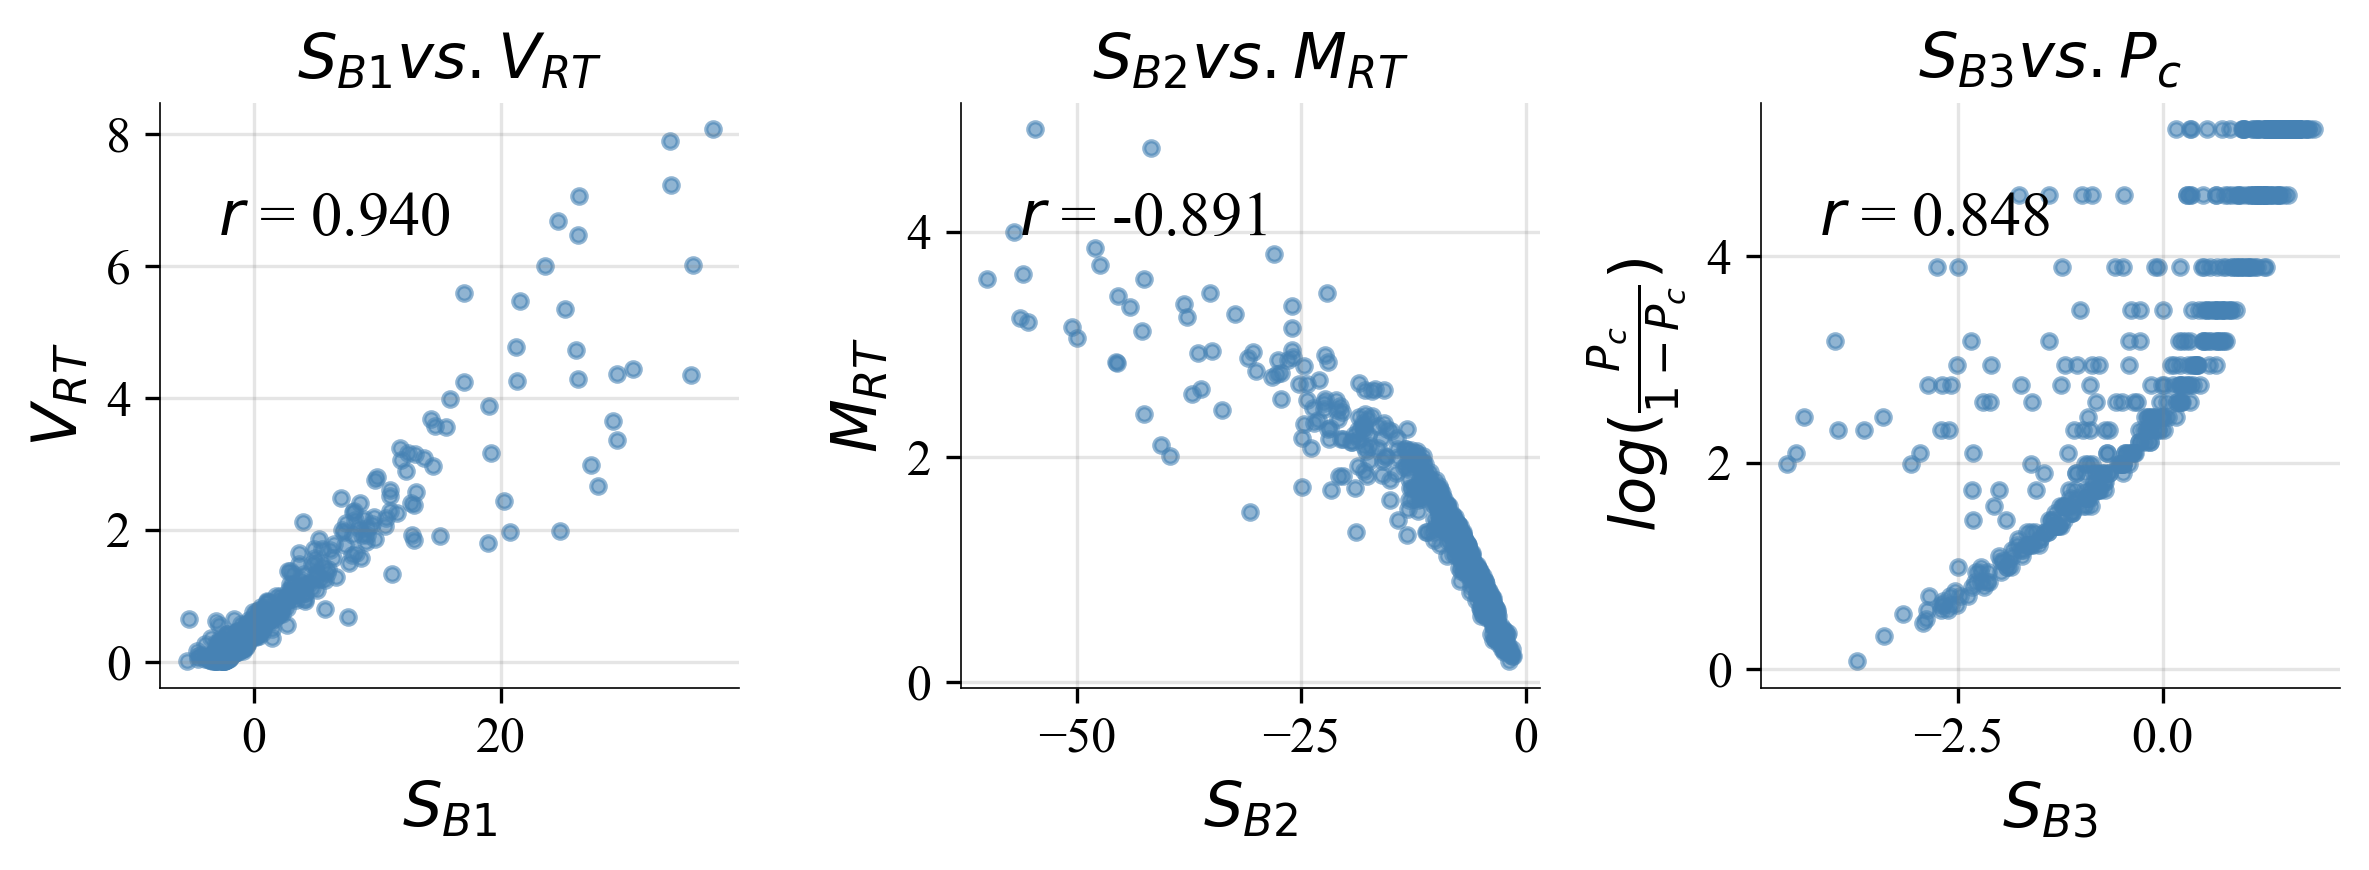

In [15]:
test_sims = validation_sims_ez
summary_stats_EZ= [VRT, MRT, Pc]
summary_stats_EZ_transform= [np.power(VRT,1), np.power(MRT,1), np.log(Pc/(1-Pc))]

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=300, figsize=(8, 3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.rcParams['font.family'] = 'Times New Roman'

# Plot data and diagonal lines
for i in range(3):
    axes[i].scatter(summary_stats[:,i], summary_stats_EZ_transform[i], marker = 'o', s=12, color='steelblue',alpha=0.6)
    axes[i].set_title([r'$S_{B1}  vs. V_{RT} $', r'$S_{B2}  vs. M_{RT}$', r'$S_{B3}  vs. P_{c}$'][i],size=15)
    axes[i].set_xlabel([r'$S_{B1}$', r'$S_{B2}$', r'$S_{B3}$'][i], size=15)
    axes[i].set_ylabel([r'$V_{RT}$', r'$M_{RT}$', r'$log(\frac{P_c}{1-P_c})$'][i], size=15)
    
    #add r
    corr = np.corrcoef(summary_stats[:,i], summary_stats_EZ_transform[i])[0, 1]
    axes[i].text(
                0.1,
                0.8,
                "$r$ = {:.3f}".format(corr),
                horizontalalignment="left",
                verticalalignment="center",
                transform=axes[i].transAxes,
                size=15
    )
    # Remove top and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    # Set grey grid
    axes[i].grid(color='grey', linestyle='-',alpha=0.2)

    # Show only bottom and left ticks
    axes[i].xaxis.set_ticks_position('bottom')
    axes[i].yaxis.set_ticks_position('left')
    
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    
    for spine in axes[i].spines.values():
        spine.set_linewidth(0.4)  # Adjust the line width here


plt.tight_layout()
plt.savefig(root_dir / 'plots/summary_statistics_in_bayesflow_and_ez_one_by_one.pdf', format="pdf", bbox_inches="tight")
plt.show()



### Run the multivariate random forest in R

In [26]:
## Save the summary statistics in EZ diffusion and BayesFlow and input them in R
# summary_stats_array = summary_stats.numpy()
# np.savetxt(root_dir / 'multivariate random forest/summary_stats_bf.txt', summary_stats_array, delimiter=',')
# np.savetxt(root_dir / 'multivariate random forest/summary_stats_ez.txt', np.column_stack((summary_stats_EZ[0],summary_stats_EZ[1],summary_stats_EZ[2])), delimiter=',')

In [31]:
# Specify the path to your text file and the delimiter (if needed)
file_path_summary_stats = root_dir / 'multivariate random forest/predicted_summary_stats_ez.txt'  # Update with the path to your text file
delimiter = ' '  # Update with the delimiter used in your text file

predicted_summary_stats_ez = pd.read_csv(file_path_summary_stats, delimiter=delimiter)

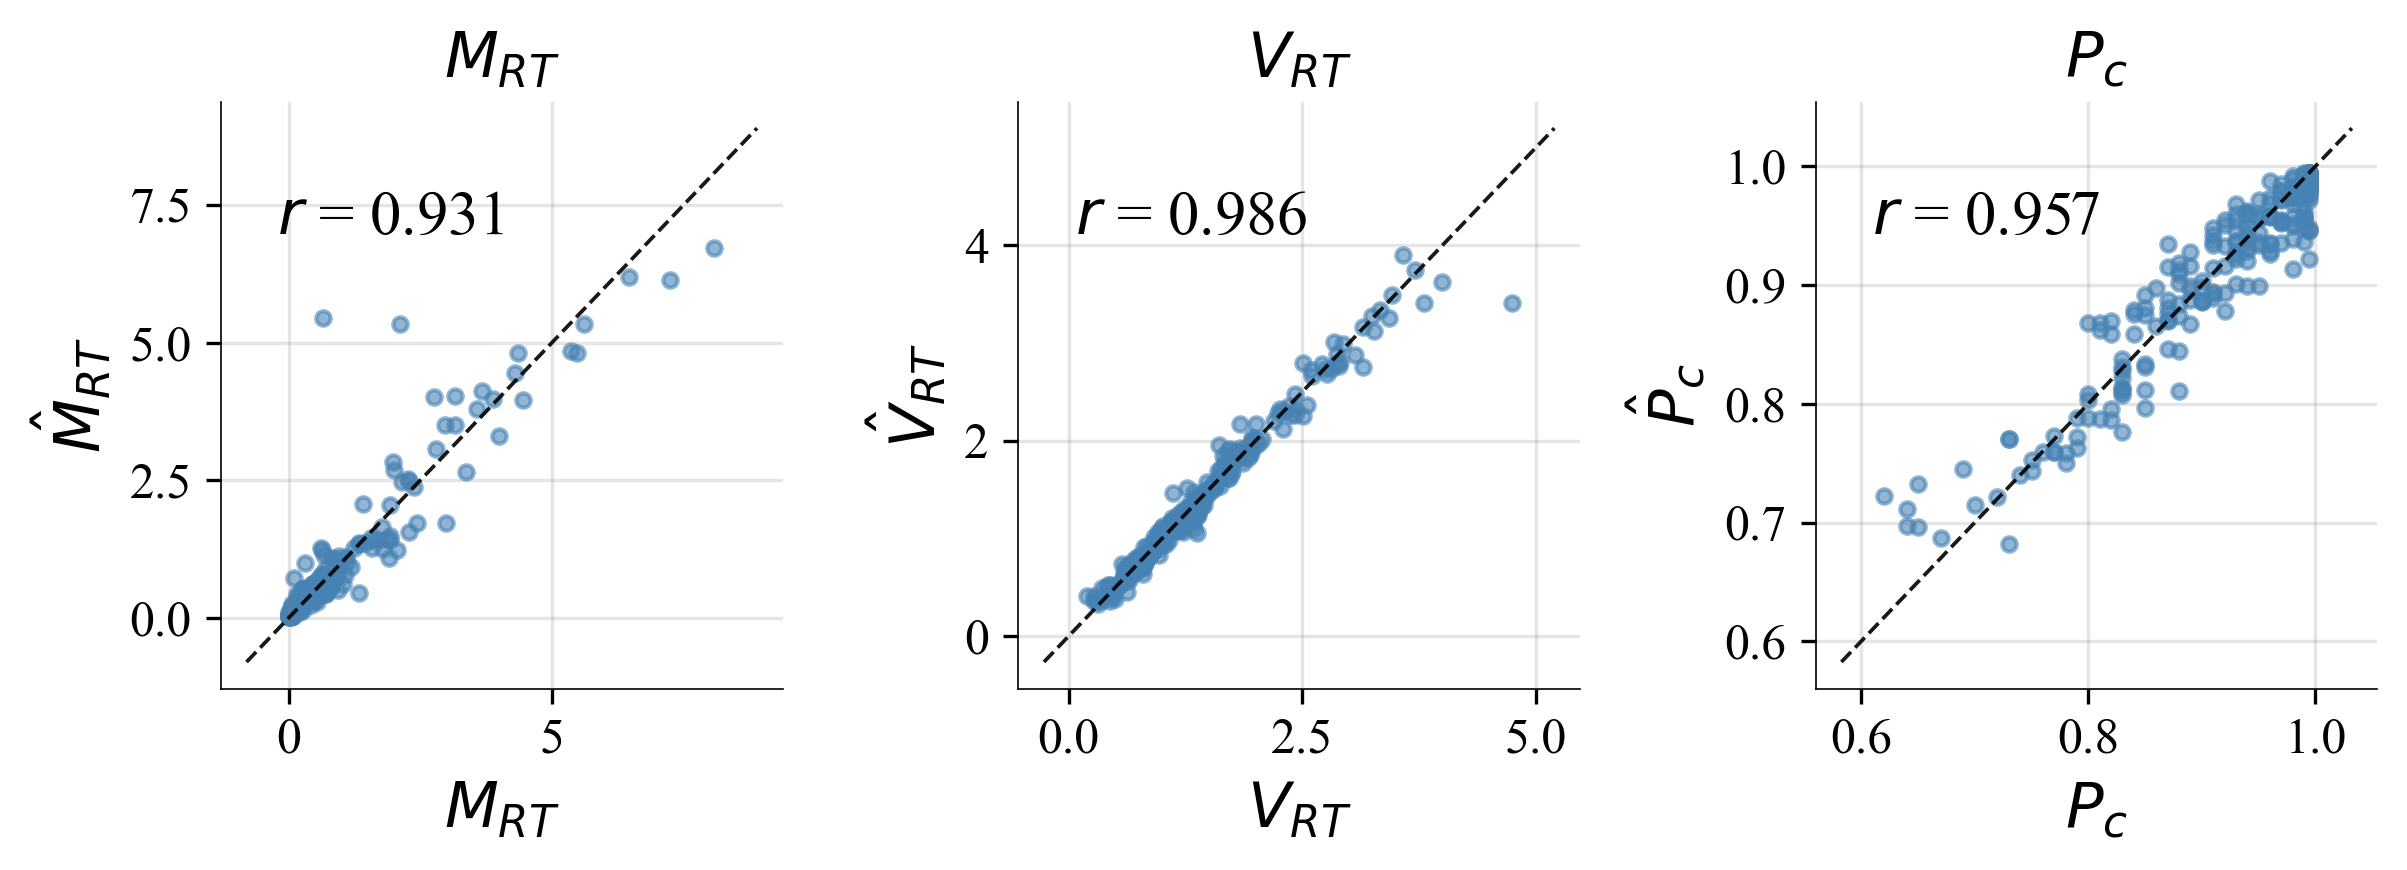

In [32]:
# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=300, figsize=(8, 3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.rcParams['font.family'] = 'Times New Roman'

# Plot data and diagonal lines
for i in range(3):
    axes[i].scatter(summary_stats_EZ[i][250:500], predicted_summary_stats_ez.iloc[:,i], marker = 'o', s=12, color='steelblue',alpha=0.6)
    axes[i].set_title([r'$M_{RT}$', r'$V_{RT}$', r'$P_c$'][i], size=15)
    axes[i].set_xlabel([r'$M_{RT}$', r'$V_{RT}$', r'$P_c$'][i], size=15)
    axes[i].set_ylabel([r'$\hat{M}_{RT}$', r'$\hat{V}_{RT}$', r'$\hat{P}_{c}$'][i], size=15)
    
    lower = min(np.array(summary_stats_EZ[i][250:500]).min(), predicted_summary_stats_ez.iloc[:,i].min())
    upper = max(np.array(summary_stats_EZ[i][250:500]).max(), predicted_summary_stats_ez.iloc[:,i].max())
    eps = (upper - lower) * 0.1
    axes[i].plot([lower - eps, upper + eps],
                 [lower - eps, upper + eps],
                 color='black', alpha=0.9, linestyle="dashed", label='Diagonal Line',linewidth=0.9)
    
    
    #add r
    corr = np.corrcoef(summary_stats_EZ[i][250:500], predicted_summary_stats_ez.iloc[:,i])[0, 1]
    axes[i].text(
                0.1,
                0.8,
                "$r$ = {:.3f}".format(corr),
                horizontalalignment="left",
                verticalalignment="center",
                transform=axes[i].transAxes,
                size=15
    )
    # Remove top and right spines
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    # Set grey grid
    axes[i].grid(color='grey', linestyle='-',alpha=0.2)

    # Show only bottom and left ticks
    axes[i].xaxis.set_ticks_position('bottom')
    axes[i].yaxis.set_ticks_position('left')
    
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    
    for spine in axes[i].spines.values():
        spine.set_linewidth(0.4)  # Adjust the line width here


plt.tight_layout()
plt.savefig(root_dir / 'plots/summary_statistics_in_bayesflow_and_ez.pdf', format="pdf", bbox_inches="tight")

plt.show()

